In [264]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scripts import StockDatabase, UtilsStockPrice

In [279]:
# Read all tickers for WIG_ODZIEZ sector
tickers = pd.read_csv("../database/designData/WIGs.csv")["WIG_ODZIEZ"].dropna()

# Load historical prices 
sdb = StockDatabase()
sdb.load_historical_data(tickers)
common_begin_date = sdb.get_common_begin_date()

# Read reports data
report = pd.read_csv("../database/reportData/WIG_ODZIEZ_COMPANY_QQ.csv", index_col=[0])
report["D_DATE"] = report["D_DATE"].astype("datetime64[s]")
report = report[report["D_DATE"] > common_begin_date]

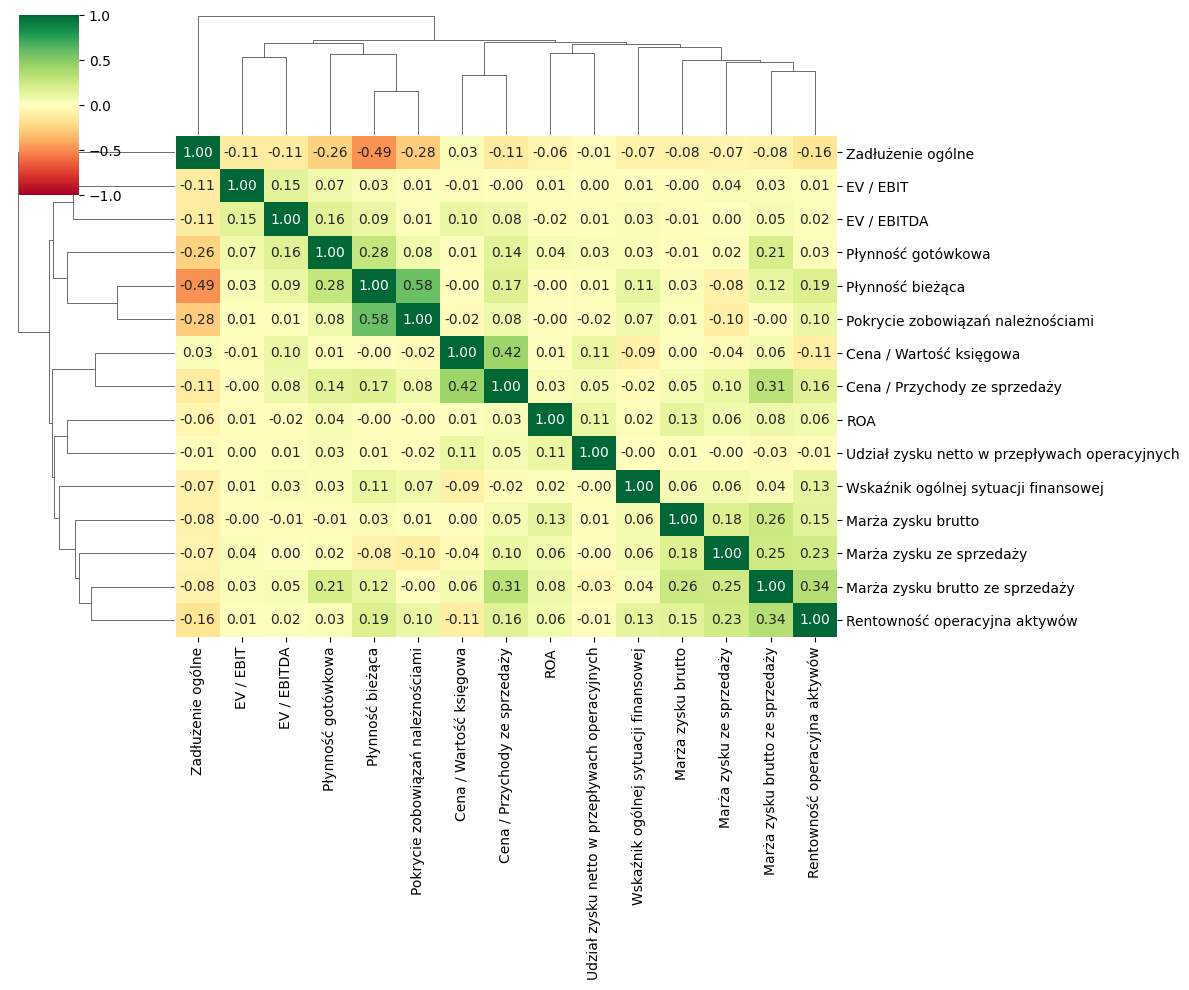

In [266]:
# Remove samples where sum(NaN feature) > 20% all feature (in sample)
report = report.dropna(axis = 0, thresh = report.shape[1] * 0.8)
# Remove feature where 
report = report.dropna(axis = 1, thresh = report.shape[0] * 0.8)

# Select not important features base on correlation > |0.7|
NOT_IMPORTANT_FEATURES = [
    "Zastosowanie kapitału obcego",
    "Zadłużenie kapitału własnego",
    "ROE",
    "Marża zysku netto",
    "Marża zysku operacyjnego",
    "EV / Przychody ze sprzedaży",
    "I stopień pokrycia",
    "Płynność szybka",
]
# Remove not important feature
report = report.drop(columns=NOT_IMPORTANT_FEATURES)

# Display correlation matrix
sns.clustermap(report.drop(columns=["D_DATE", "Ticker"]).corr(), 
               cmap='RdYlGn', vmin=-1, vmax=1, fmt='.2f', annot=True, figsize=(12, 10))
plt.show()


In [280]:
# Fill NaN value base on KNNImputer
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=3)
X_train = imputer.fit_transform(report.drop(columns=["D_DATE", "Ticker"]))

In [281]:
# Prepare Y
WINDOW_SIZE = 10

def average_companies_return(tickers, date, window):
    cmps = []
    for ticker in tickers:
        cmps.append(UtilsStockPrice.average_return(sdb.get_historical_data(ticker), 
                                                   date, window=window))
    return np.array(cmps).mean()


reference_return = []
for _, row in report.iterrows():
    date, ticker = row[:2]
    cmp_return = UtilsStockPrice.average_return(sdb.get_historical_data(ticker), date, window=WINDOW_SIZE)
    sec_return = average_companies_return(tickers[tickers != ticker], date, WINDOW_SIZE)
    reference_return.append(cmp_return - sec_return)

reference_return = np.array(reference_return)

In [282]:
# TODO Remove outstanding data
rr_mean = reference_return.mean()
rr_std = reference_return.std()

map_to_remove = np.all([reference_return < rr_mean + 3 * rr_std, 
                        reference_return > rr_mean - 3 * rr_std], axis=0)
reference_return = reference_return[map_to_remove]
X_train = X_train[map_to_remove]

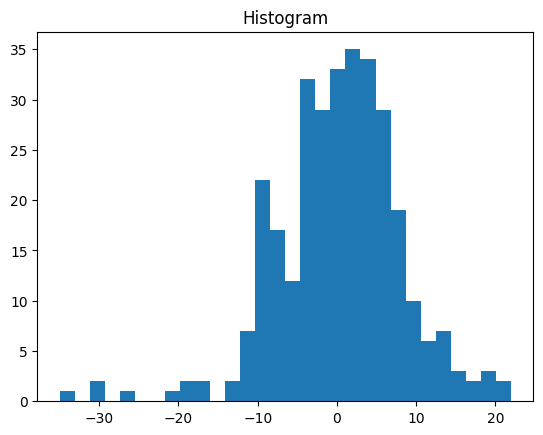

In [283]:
plt.hist(reference_return, bins=30)  # arguments are passed to np.histogram
plt.title("Histogram")
plt.show()

In [284]:
from scipy.stats import norm
loc, scale = norm.fit(reference_return)

In [285]:
bins_border = norm.ppf([0, 0.3, 0.35, 0.65, 0.7, 1], loc=loc, scale=scale)

In [286]:
cat = pd.cut(np.array(reference_return), bins=bins_border, labels=[-2, -1, 0, 1, 2]).to_numpy()

In [287]:
X_train = X_train[cat!=-1]
cat = cat[cat!=-1]
X_train = X_train[cat!=1]
cat = cat[cat!=1]
X_train = X_train[cat!=0]
cat = cat[cat!=0]

In [288]:
np.unique(cat, return_counts=True)

(array([-2,  2]), array([84, 91]))

In [289]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X_train, cat, test_size=0.3)

In [290]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=1000, max_depth=6, n_jobs=-1)
clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=6, n_estimators=1000, n_jobs=-1)

ACC = 0.6226415094339622
score = 0.6226415094339622


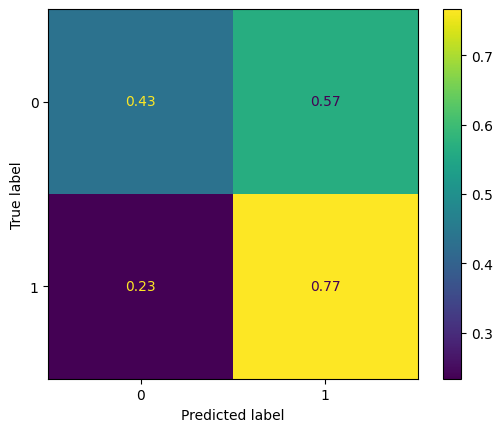

In [291]:
from sklearn import metrics 
y_pred = clf.predict(X_test)

# Jakość klasyfikacji
acc = metrics.accuracy_score(y_test, y_pred)

# Macierz pomyłek
cm = metrics.confusion_matrix(y_test, y_pred, labels=clf.classes_, normalize='true')

print(f"ACC = {acc}")
print(f"score = {clf.score(X_test, y_test)}")
disp = metrics.ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()